## Mount the google in the content ##

In [1]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


## Creat Model ##

In [ ]:
import tensorflow as tf
from  tensorflow import keras
from  tensorflow.keras import layers, Sequential

class BasicBlock(layers.Layer):

    def __init__(self, filter_num, stride=1):
        super(BasicBlock, self).__init__()

        self.conv1 = layers.Conv2D(filter_num, (3, 3), strides=stride, padding='same')
        self.bn1 = layers.BatchNormalization()
        self.relu = layers.Activation('relu')

        self.conv2 = layers.Conv2D(filter_num, (3, 3), strides=1, padding='same')
        self.bn2 = layers.BatchNormalization()

        if stride != 1:
            self.downsample = Sequential()
            self.downsample.add(layers.Conv2D(filter_num, (1, 1), strides=stride))
        else:
            self.downsample = lambda x:x

    def call(self, inputs, training=None):

        # [b, h, w, c]
        out = self.conv1(inputs)
        out = self.bn1(out,training=training)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out,training=training)

        identity = self.downsample(inputs)

        output = layers.add([out, identity])
        output = tf.nn.relu(output)

        # output = layers.add(Dense(10, activation='softmax'))
        return output


class ResNet(keras.Model):


    def __init__(self, layer_dims, num_classes = 10): # [2, 2, 2, 2]
        super(ResNet, self).__init__()

        self.stem = Sequential([layers.Conv2D(64, (3, 3), strides=(1, 1)),
                    layers.BatchNormalization(),
                    layers.Activation('relu'),
                    layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1), padding='same')
                    ])

        self.layer1 = self.build_resblock(64,  layer_dims[0])
        self.layer2 = self.build_resblock(128, layer_dims[1], stride=2)
        self.layer3 = self.build_resblock(256, layer_dims[2], stride=2)
        self.layer4 = self.build_resblock(512, layer_dims[3], stride=2)

        # output: [b, 512, h, w],
        self.avgpool = layers.GlobalAveragePooling2D()
        self.flatten11 = layers.Flatten(name='flatten11')

        self.fc1 = layers.Dense(1700, activation='relu', use_bias=False)
        self.fc2 = layers.Dense(800, activation='relu', use_bias=False)
        self.fc3 = layers.Dense(num_classes, activation='softmax', use_bias=False)


    def call(self, inputs, training=None):

        x = self.stem(inputs,training=training)

        x = self.layer1(x,training=training)
        x = self.layer2(x,training=training)
        x = self.layer3(x,training=training)
        x = self.layer4(x,training=training)


        x = self.avgpool(x)


        #================= train time =========================
        # x = self.flatten11(x)
        # x = self.fc1(x)
        # x = self.fc2(x)
        # x = self.fc3(x)
        # return x

        #================= use time =========================
        intermediate_output = self.flatten11(x)
        x = self.fc1(intermediate_output)
        x = self.fc2(x)
        x = self.fc3(x)
        return x, intermediate_output

    def build_resblock(self, filter_num, blocks, stride=1):

        res_blocks = Sequential()
        # may down sample
        res_blocks.add(BasicBlock(filter_num, stride))

        for _ in range(1, blocks):
            res_blocks.add(BasicBlock(filter_num, stride=1))

        return res_blocks


def resnet18():
    return ResNet([2, 2, 2, 2])


def resnet34():
    return ResNet([3, 4, 6, 3])

In [ ]:
import  os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from keras import layers, optimizers, datasets, Sequential
from tensorflow.keras.utils import get_custom_objects

tf.random.set_seed(21)

if __name__ == '__main__':
  model = resnet18()
  model.build(input_shape=(None, 32, 32, 3))

  (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
  print(x_train.shape)
  y_train = to_categorical(y_train)
  y_test = to_categorical(y_test)
  model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
  modelcifar_CNN = model
  modelcifar_CNN.summary()
  history = modelcifar_CNN.fit(x_train, y_train, batch_size = 256, epochs = 15, validation_data=(x_test, y_test))
  # # model specific

  # # # How to evaluate
  loss, acc = modelcifar_CNN.evaluate(x_test, y_test, verbose=2)


170498071/170498071 [==============================] - 14s 0us/step
(50000, 32, 32, 3)
Model: "res_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 30, 30, 64)        2048      
                                                                 
 sequential_1 (Sequential)   (None, 30, 30, 64)        148736    
                                                                 
 sequential_2 (Sequential)   (None, 15, 15, 128)       526976    
                                                                 
 sequential_4 (Sequential)   (None, 8, 8, 256)         2102528   
                                                                 
 sequential_6 (Sequential)   (None, 4, 4, 512)         8399360   
                                                                 
 global_average_pooling2d (G  multiple                 0         
 lobalAveragePooling2D)               

## Save Model and Data ##

In [3]:
# import matplotlib.pyplot as plt
# plt.plot(history.history['accuracy'], label='accuracy')
# plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.ylim([0.3, 0.95])
# plt.legend(loc='lower right')
# plt.show()
# modelcifar_CNN.summary()
import numpy as np
from tensorflow.keras.utils import to_categorical
filepath = ("/content/drive/MyDrive/PBCDcode/Cifar10Resnet18/data/prenetwork/cifarresnet18CNN.h5")  # cifarCNN1.h5"
# modelcifar_CNN.save_weights(filepath, overwrite = True, save_format = None, options = None)
model = resnet18()
model.build(input_shape=(None, 32, 32, 3))

model.load_weights(filepath)


input_data = tf.random.normal(shape=(16, 32, 32, 3))  # 示例：输入数据 # 示例：输入数据
_, interput = model(input_data)  # 调用第一层的输出

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()  # 100分类
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

test_images = []
for i in range(100):
  _, test_0 = model(x_test[i*100:(i+1)*100,:,:])
  if i ==0:
    test_images = test_0.numpy().T
  else:
    test_images = np.hstack((test_images, test_0.numpy().T))
print(test_images.shape)  # (3072, 10000)

train_images = []
for i in range(500):
  _, train_0 = model(x_train[i*100:(i+1)*100,:,:])
  if i ==0:
    train_images = train_0.numpy().T
  else:
    train_images = np.hstack((train_images, train_0.numpy().T))

np.save("/content/drive/MyDrive/PBCDcode/Cifar10Resnet18/data/rawdata/train_images.npy", train_images.T)
np.save("/content/drive/MyDrive/PBCDcode/Cifar10Resnet18/data/rawdata/test_images.npy", test_images.T)  # (10000, 3072)

np.save("/content/drive/MyDrive/PBCDcode/Cifar10Resnet18/data/rawdata/train_labels.npy", y_train)
np.save("/content/drive/MyDrive/PBCDcode/Cifar10Resnet18/data/rawdata/test_labels.npy", y_test)



NameError: ignored

# Define some parameters, functions and models

In [4]:
import numpy as np   # science calculate  instill numpy

import struct  # y???????
from sklearn.utils import shuffle  # instill scikit-learn/ scikit
import time
import os  # o??????????
import scipy
from scipy import io
import torch as tc
import tensorflow as tf
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

from tqdm import tqdm, trange
from tensorflow.keras import datasets
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense,Conv2D,Dropout,Flatten,Activation,BatchNormalization,AveragePooling2D,MaxPooling2D
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from keras.backend import sigmoid
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))
from tensorflow.keras.utils import get_custom_objects
from keras.layers import Activation

# Define some new activations
get_custom_objects().update({'swish': Activation(swish)})

def binary(x):
  return tf.maximum(-1.0, tf.minimum(1.0, x))
get_custom_objects().update({'binary': Activation(binary)})
def binary_derivative(x):
  x = x.numpy()
  tp = np.ones(x.shape)
  tp *= (x <= 1)
  tp *= (x >= -1)
  return tf.convert_to_tensor(tp, dtype = tf.float32)

get_custom_objects().update({'binary': Activation(binary)})


from keras.layers import LeakyReLU
def Leakeyrelu(x):
    return tf.keras.layers.LeakyReLU(alpha=0.02)(x)
get_custom_objects().update({'Leakeyrelu': Activation(Leakeyrelu)})

def ccnn(x):
    # 自定义激活函数逻辑，例如 sigmoid
    return tf.sign(x * tf.cast(x >= 0, dtype=tf.float32))

def ccnn_derivative(x):
    # 计算自定义激活函数的导数
    x = x.numpy()
    tp = 0 * x + 0.4
    idex_row, idex_column = np.where( abs(x) <= 0.4 )
    idex0_row, idex0_column = np.where( abs(x) > 1 )
    if len(idex_row) > 0:
      tp[idex_row, idex_column] = 2 * tf.ones(len(idex_row)) - 4 * abs(x[idex_row, idex_column])
    if len(idex0_row) > 0:
      tp[idex0_row, idex0_column] = 0
    return tf.convert_to_tensor(tp, dtype = tf.float32)
get_custom_objects().update({'ccnn': Activation(ccnn)})


def pcnn(x):
    # 自定义激活函数逻辑，例如 sigmoid
    return 0.02 * tf.maximum(-1.0, tf.minimum(1.0, x))

def pcnn_derivative(x):
  x = x.numpy()
  tp = np.ones(x.shape)
  tp *= (x <= 1)
  tp *= (x >= -1)
  return tf.convert_to_tensor(tp, dtype = tf.float32)
get_custom_objects().update({'pcnn': Activation(pcnn)})

def bira(x):
    # 自定义激活函数逻辑，例如 sigmoid
    return tf.maximum(-1.0, tf.minimum(1.0, x))

def bira_derivative(x):
  x = x.numpy()
  x1 = x + 2
  x2 = x - 2
  x1 *= (x >= -1)
  x1 *= (x <= 0)

  x2 *= (x >= 0)
  x2 *= (x <= 1)

  return tf.convert_to_tensor(x1 + x2, dtype = tf.float32)
get_custom_objects().update({'bira': Activation(bira)})



def hardmax(x):  # 返回矩阵值 dimision: 10 * 64
    v1 = np.zeros(x.shape)
    v = np.argmax(x, 0)  # tf.argmax(a,1) 每一列最大值位置
    for i in range(x.shape[1]):
        v1[v[i], i] = 1
    return tf.convert_to_tensor(v1, dtype=tf.float32)

def forward_propagation(X, parameters):
    W1 = parameters["W1"]  # W1 维数 （784, 1000）
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    U1 = tf.matmul(tf.transpose(W1), X.T)  # + b1 * parameters['gamma1']
    # betch_size =16, nx*nx = 784 X为（784，16）, gamma1为nx*nx，X * gamma1的维数和X维数相同
    V1 = tf.sign(U1 + 1.e-10)  # 实现Relu，V1为 (1000，16)为第1隐层的值
    U2 = tf.matmul(tf.transpose(W2), V1)  # + b2    # W2^T 维数 （1000,1000） * parameters['gamma2']
    V2 = tf.sign(U2 + 1.e-10)  # 实现Relu，V2 (1000，16)为第2隐层的值
    U3 = tf.matmul(tf.transpose(W3), V2)  # + b3    # W3^T为 （10，1000） * parameters['gamma3']
    V3 = hardmax(U3)  # 输出 维数是10*batch 大小
    return tf.transpose(V3)

def costloss(V3, Y):
    cost = tf.square(tf.norm(V3 - Y)) / 2
    return cost

def errorloss(x_train, y_train, x_test, y_test, model_all):
    W1 = model_all.layers[0].get_weights()
    W1 = W1[0]
    W2 = model_all.layers[2].get_weights()
    W2 = W2[0]
    W3 = model_all.layers[4].get_weights()
    W3 = W3[0]
    parameters_in = { "W1": W1,
              "W2": W2,
              "W3": W3 }
    aa25 = forward_propagation(x_train, parameters_in)
    acc_train = (60000 - costloss(aa25, y_train))/60000
    aa25 = forward_propagation(x_test, parameters_in)
    acc_test = (10000 - costloss(aa25, y_test)) / 10000
    return acc_train, acc_test

def layer2_model(act_my):
  # chanDim = -1
  model = Sequential()
  model.add(Dense(2000, use_bias=False))
  model.add(Activation(act_my))
  model.add(Dense(1000, use_bias=False))
  model.add(Activation(act_my))

  model.add(Dense(10, activation='softmax', use_bias=False))
  model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
  return model

# Train process

In [ ]:
myacti = {0: "relu",
      1: "sigmoid",
      2: "swish",
      3: "selu",
      4: "tanh",
      5: "binary",
      6: "ccnn",
      7: "pcnn",
      8: "bira"
      }
directory0 = ("/content/drive/MyDrive/PBCDcode/Cifar10Resnet18/data/")
directorybase = ("/content/drive/MyDrive/PBCDcode/Cifar10Resnet18/data/activations")
if not os.path.exists(directorybase):
  os.makedirs(directorybase)
x_train = np.load(os.path.join(directory0, "rawdata/train_images.npy"))
x_test = np.load(os.path.join(directory0, "rawdata/test_images.npy"))
y_train = np.load(os.path.join(directory0, "rawdata/train_labels.npy"))
y_test = np.load(os.path.join(directory0, "rawdata/test_labels.npy"))

pre_N = 2
formal_N = 40
train_all_time = 5

for acti_now in range(len(myacti)):
  if acti_now > 4:# decide what do I select Myacti
    print("========================================================")
    print("The current activation is: {},".format(myacti[acti_now]))
    print("========================================================")
    print("========================================================")

    historytrain_all = np.zeros((50, train_all_time))
    historytest_all = np.zeros((50, train_all_time))
    for tm in range(train_all_time):
      tf.random.set_seed(21 + tm *21)
      historytrain = np.zeros((50, 1))
      historytest = np.zeros((50, 1))
      model = layer2_model(myacti[acti_now])
      if acti_now == -5:
        nu = 0
        for full in range(pre_N):
          history1 = model.fit( x_train, y_train, epochs= 1, batch_size = 256, validation_data=(x_test, y_test) )
          historytrain[nu], historytest[nu] = errorloss(x_train, y_train, x_test, y_test, model)
          nu += 1
        for formal in range(formal_N):
          history2 = model.fit( x_train, y_train, epochs= 1, batch_size = 60000, validation_data=(x_test, y_test) )
          historytrain[nu], historytest[nu] = errorloss( x_train, y_train, x_test, y_test, model )
          nu += 1
      else:
        history1 = model.fit(x_train, y_train, epochs= pre_N, batch_size = 256, validation_data=(x_test, y_test) )
        history2 = model.fit(x_train, y_train, epochs= formal_N, batch_size = 60000, validation_data=(x_test, y_test))
        history_dict1 = history1.history
        history_dict2 = history2.history
        historytrain[0:pre_N+formal_N] = (np.append(np.array(history_dict1['accuracy']), np.array(history_dict2['accuracy']))).reshape(pre_N+formal_N,1)
        historytest[0:pre_N+formal_N] = (np.append(np.array(history_dict1['val_accuracy']), np.array(history_dict2['val_accuracy']))).reshape(pre_N+formal_N,1)

      historytrain_all[:, tm] = historytrain.reshape(50,)
      historytest_all[:, tm] = historytest.reshape(50,)
    directory = os.path.join(directorybase, myacti[acti_now] + "network")
    directory_1 = os.path.join(directory, "historytrain_all"+'.npy')
    directory_2 = os.path.join(directory, "historytest_all"+'.npy')
    if not os.path.exists(directory):
      os.makedirs(directory)
    np.save(directory_1, historytrain_all)
    np.save(directory_2, historytest_all)




The current activation is: binary,
Epoch 1/2
196/196 [==============================] - 3s 10ms/step - loss: 0.1573 - accuracy: 0.9530 - val_loss: 0.9184 - val_accuracy: 0.8054
Epoch 2/2
196/196 [==============================] - 2s 12ms/step - loss: 0.1120 - accuracy: 0.9623 - val_loss: 0.8815 - val_accuracy: 0.8104
Epoch 1/40
1/1 [==============================] - 1s 808ms/step - loss: 0.0969 - accuracy: 0.9671 - val_loss: 0.8929 - val_accuracy: 0.8109
Epoch 2/40
1/1 [==============================] - 0s 355ms/step - loss: 0.1018 - accuracy: 0.9659 - val_loss: 0.9077 - val_accuracy: 0.8093
Epoch 3/40
1/1 [==============================] - 0s 420ms/step - loss: 0.1078 - accuracy: 0.9634 - val_loss: 0.9157 - val_accuracy: 0.8082
Epoch 4/40
1/1 [==============================] - 0s 426ms/step - loss: 0.1095 - accuracy: 0.9634 - val_loss: 0.9139 - val_accuracy: 0.8089
Epoch 5/40
1/1 [==============================] - 0s 369ms/step - loss: 0.1052 - accuracy: 0.9644 - val_loss: 0.9071 - va

# Show picture

0
1
2
3
4
5
6
7
8
9


<ipython-input-5-73f40d76b85e>:53: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark')


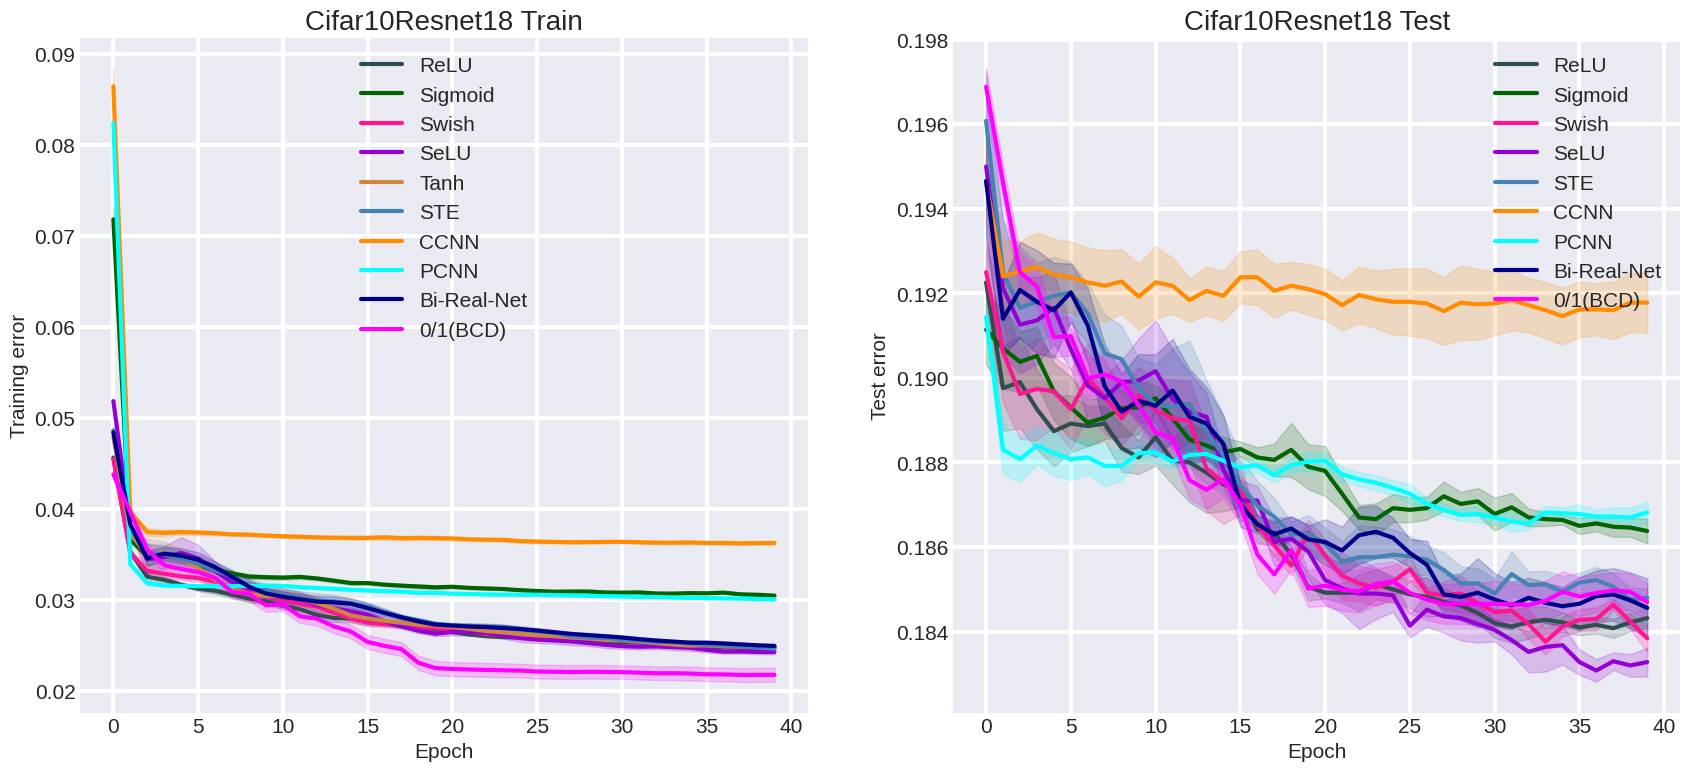

In [5]:
result_plot = {}
directorybase = ("/content/drive/MyDrive/PBCDcode/Cifar10Resnet18/data/activations")
myacti = {0: "relu",
      1: "sigmoid",
      2: "swish",
      3: "selu",
      4: "tanh",
      5: "binary",
      6: "ccnn",
      7: "pcnn",
      8: "bira",
      9: "01"}

Or_name = {0: "ReLU",
      1: "Sigmoid",
      2: "Swish",
      3: "SeLU",
      4: "Tanh",
      5: "STE",
      6: "CCNN",
      7: "PCNN",
      8: "Bi-Real-Net",
      9: "0/1(BCD)"}

color_all = {0: "darkslategrey",
        1: "darkgreen",
        2: "deeppink",
        3: "darkviolet",
        4: "peru",
        5: "steelblue",
        6: "darkorange",
        7: "cyan",
        8: "darkblue",
        9: "magenta"
       }
train_all_time = 5
plotN = 40
for i in range(len(myacti)):
  print(i)
  directory = os.path.join(directorybase, myacti[i] + "network")
  history_dict1 = np.load(os.path.join(directory, "historytrain_all"+'.npy'))
  history_dict2 = np.load(os.path.join(directory, "historytest_all"+'.npy'))
  history_dict1 = history_dict1[0:plotN,:]
  history_dict2 = history_dict2[0:plotN,:]
  result_plot[myacti[i] + "-mean-train"] = 1 - history_dict1.mean(axis=1)
  result_plot[myacti[i] + "-mean-test"] = 1 - history_dict2.mean(axis=1)
  result_plot[myacti[i] + "-std-train"] = np.linalg.norm(history_dict1-history_dict1.mean(axis=1)[:,None], axis = 1)/train_all_time
  result_plot[myacti[i] + "-std-test"] = np.linalg.norm(history_dict2-history_dict2.mean(axis=1)[:,None], axis = 1)/train_all_time

# Error avanrange picture
fig = plt.figure(figsize=(20,9))
plt.style.available
plt.style.use('seaborn-dark')
plt.subplots_adjust(left=0.1, bottom=0.15, right=0.9, top=0.9, hspace=0.2, wspace=0.2)

plt.subplot(1,2,1)
result_plot['epoch'] = range(plotN)

for act in range(len(myacti)): #
  plt.plot(result_plot['epoch'], result_plot[str(myacti[act])+'-mean-train'], c = color_all[act], alpha = 1, linewidth=3, label = Or_name[act])
  plt.fill_between(result_plot['epoch'],  result_plot[str(myacti[act])+'-mean-train']-result_plot[str(myacti[act])+'-std-train'], result_plot[str(myacti[act])+'-mean-train'] + result_plot[str(myacti[act])+'-std-train'], color=color_all[act], alpha=0.2)

plt.grid(lw=3)
plt.legend(fontsize=15, loc='upper center',)
# plt.xlabel('Model settings',fontsize=15)

plt.xlabel('Epoch',fontsize=15)
plt.ylabel('Training error',fontsize=15)
plt.title('Cifar10Resnet18 Train',fontsize=20)
plt.tick_params(labelsize=15)

plt.subplot(1,2,2)

for act in range(len(myacti)): # len(myacti))
  if act != 4:
    plt.plot(result_plot['epoch'], result_plot[str(myacti[act])+'-mean-test'], c = color_all[act], alpha = 1, linewidth=3, label = Or_name[act])
    plt.fill_between(result_plot['epoch'],  result_plot[str(myacti[act])+'-mean-test']-result_plot[str(myacti[act])+'-std-test'], result_plot[str(myacti[act])+'-mean-test'] + result_plot[str(myacti[act])+'-std-test'], color=color_all[act], alpha=0.2)

plt.grid(lw=3)
plt.legend(fontsize=15)
plt.xlabel('Model settings',fontsize=15)

plt.xlabel('Epoch',fontsize=15, )
plt.ylabel('Test error',fontsize=15)
plt.title('Cifar10Resnet18 Test',fontsize=20)
plt.tick_params(labelsize=15)

# directoryf = ("/content/drive/MyDrive/PBCDcode/Cifar10Resnet18/data/result")
# plt.savefig(os.path.join(directoryf, "final_result.pdf"))
plt.show()

# print(history_test[7, 0:30])

In [6]:
for i in range(len(myacti)):
  print(myacti[i])
  print(result_plot[myacti[i] + "-mean-train"][39])
  print(result_plot[myacti[i] + "-mean-test"][39])
  print("=========================")

relu
0.02478801012039189
0.1843199968338013
sigmoid
0.03049999475479126
0.18638000488281248
swish
0.02486399412155149
0.18384000062942507
selu
0.024299991130828813
0.18327999114990234
tanh
0.024884009361267112
0.18430001735687251
binary
0.02465599775314331
0.1847999930381775
ccnn
0.0362680077552795
0.19178000688552854
pcnn
0.03007198572158809
0.1868200063705444
bira
0.0249719977378845
0.18456001281738277
01
0.02179732204895013
0.1847065375308038


In [ ]:
myacti = {0: "relu",
      1: "sigmoid",
      2: "swish",
      3: "selu",
      4: "tanh",
      5: "binary",
      6: "01"}
train_all_time = 5
plotN = 40
for i in range(len(myacti)):
  print("=====================================")
  print(myacti[i])
  print(min(result_plot[myacti[i] + "-mean-train"]))
  print(min(result_plot[myacti[i] + "-mean-test"]))

In [ ]:
def bira_derivative(x):
  x = x.numpy()
  x1 = x + 2
  x2 = x - 2
  x1 *= (x >= -1)
  x1 *= (x <= 0)

  x2 *= (x >= 0)
  x2 *= (x <= 1)

  return tf.convert_to_tensor(x1 + x2, dtype = tf.float32)

t = tf.random.uniform([3, 2], minval = -2, maxval = 2, dtype=tf.dtypes.float32, seed=None, name=None)
print(t)
print(bira_derivative(t))
# p = ccnn_derivative(t)
# print(p)

tf.Tensor(
[[-1.9005127  1.4448833]
 [-1.0740824 -0.2953868]
 [-1.7186651  0.336071 ]], shape=(3, 2), dtype=float32)
tf.Tensor(
[[ 0.         0.       ]
 [ 0.         1.7046132]
 [ 0.        -1.663929 ]], shape=(3, 2), dtype=float32)
